# Decision boundary plot

The idea of this is to try to create an algorithm that samples from a hyper-plane in n-dimensions that is generated by some classification algorithm.

I than project the original data and the samples with PCA into two dimensions and plot the decision boundary.

Unlike other algorithms I've come by - this one actually samples from the hyper-plane in n-dimensions and not only predict from an already projected down to 3-d version of the data.

In [5]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Generate some toy data

In [388]:
hMan = np.random.normal(loc = 175, scale = 5, size=10000)
wMan = (hMan - 100) + np.random.normal(scale=5, size=10000)
mBlonde = np.random.binomial(1, 0.25, 10000)
mAltra = np.random.binomial(10, 0.3, 10000)

hWman = np.random.normal(loc = 162, scale = 5, size=10000)
wWman = (hWman - 110) + np.random.normal(scale=5, size=10000)
Wblonde = np.random.binomial(1, 0.37, 10000)
wAltra = np.random.binomial(10, 0.7, 10000)

In [389]:
height = np.concatenate((hMan, hWman))
weight = np.concatenate((wMan, wWman))
blonde = np.concatenate((mBlonde, Wblonde))
altra = np.concatenate((mAltra, wAltra))

In [390]:
X = pd.DataFrame(height, columns=['height'])
X['weight'] = weight
X['blonde'] = blonde
X['altra'] = altra

In [392]:
y = []
for i in range(20000):
    if i < 10000:
        y.append(1)
    else:
        y.append(0)

Predict in 3D

In [447]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

In [397]:
adaMod = AdaBoostClassifier(n_estimators=5).fit(X,y)

In [398]:
confusion_matrix(y, adaMod.predict(X))

array([[9630,  370],
       [ 111, 9889]])

### PCA

In [401]:
from sklearn.decomposition import PCA

In [402]:
pcaMod = PCA(n_components=2)

In [403]:
xPca = pd.DataFrame(pcaMod.fit_transform(X), columns=['PC1', 'PC2'])

In [404]:
xPca['y'] = y

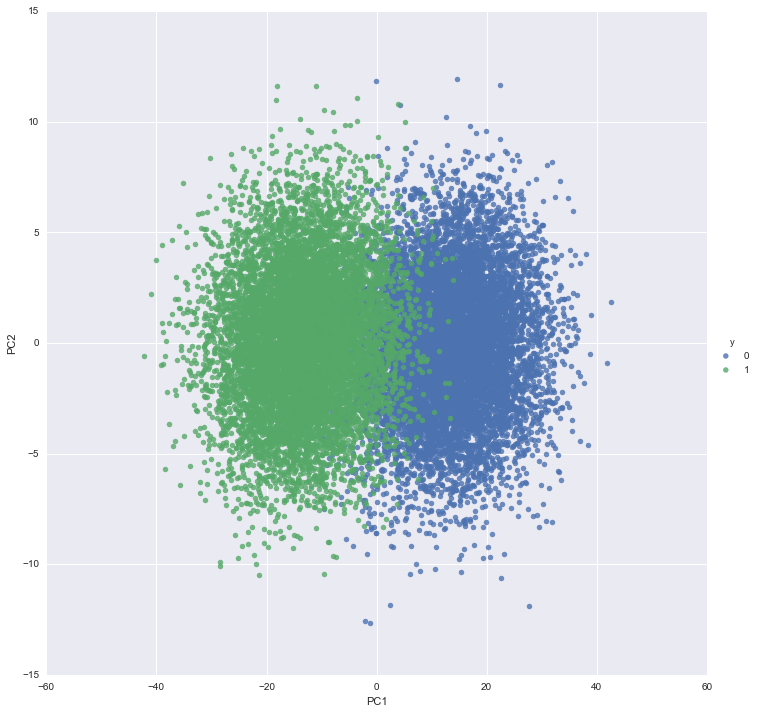

In [412]:
sns.lmplot(data=xPca, x='PC1', y='PC2', hue='y', fit_reg=False, size=10, scatter_kws={'s': 30})
plt.show()

### Find desicion boundery

In [417]:
def getFfPoints(clf, data, n_points = 100, max_try = 300, a = 1, distFromFf = 0.005, uniqueOnly = False, verbose=False):
    
    nCol = range(data.shape[1])
    ffPoint = {}
    
    #Complexity control for max number of iterations
    for i in range(max_try):
        
        #pick a point to start
        point = []
        for col in data.columns:
            
            point.append(np.random.choice(data[col]))
        
            #Columns that will be fixed and one that we'll iterate over
            changeCols = np.random.choice(nCol, replace=False, size=1)
            fixedCols = np.delete(nCol, changeCols)

        #Determine the range of values the changing col can take
        minVal = data[changeCols].min()[0]
        maxVal = data[changeCols].max()[0]

        n_iter = int((maxVal-minVal)/a)

        for j in range(n_iter):
            
            #Update and predict the point
            point[changeCols] = float(minVal + (a * j))

            #Chack if it's over the Max
            if point[changeCols] >= maxVal:
                break

            point = np.array(point)
            pred = clf.predict_proba(point.reshape(1,-1))[0][1]
            
            #If the point is closer to 0.5 prediction than distFromFf store it in a Dict with key j
            if abs(pred-0.5) <= abs(0.5-(0.5+distFromFf)):
                ffPoint[len(ffPoint)+1] = point
                if ((verbose == True) & (len(ffPoint) % 10 == 0)):
                    print 'points created {}'.format(len(ffPoint))

            if len(ffPoint) == n_points:
                
                nUnique = len(pd.DataFrame(ffPoint).T.drop_duplicates())
                nPoints = len(ffPoint)
                uniqueRatio = float(nUnique)/float(nPoints)
                              
                print 'Points generated: {}'.format(nPoints)
                print 'Unique points: {} / {} ({:.3f}%)'.format(nUnique, nPoints, uniqueRatio)
                
                if uniqueOnly == False:
                    return pd.DataFrame(ffPoint).T
                else:
                    return pd.DataFrame(ffPoint).T.drop_duplicates()
    
    try:
        nUnique = len(pd.DataFrame(ffPoint).T.drop_duplicates())
        nPoints = len(ffPoint)
        uniqueRatio = float(nUnique)/float(nPoints)

        print 'Unable to create {} points with max_try = {}'.format(n_points, max_try)
        print 'Points generated: {}'.format(nPoints)
        print 'Unique points: {} / {} - {:.3f}%'.format(nUnique, nPoints, uniqueRatio)


        if uniqueOnly == False:
            return pd.DataFrame(ffPoint).T
        else:
            return pd.DataFrame(ffPoint).T.drop_duplicates()
    
    except:
        print 'Zero points found!'
        return pd.DataFrame(ffPoint).T

In [ ]:
ffPoints = getFfPoints(adaMod, X, distFromFf=0.05, max_try=2000 ,n_points=2000, a=0.5, verbose=True)

### Plot

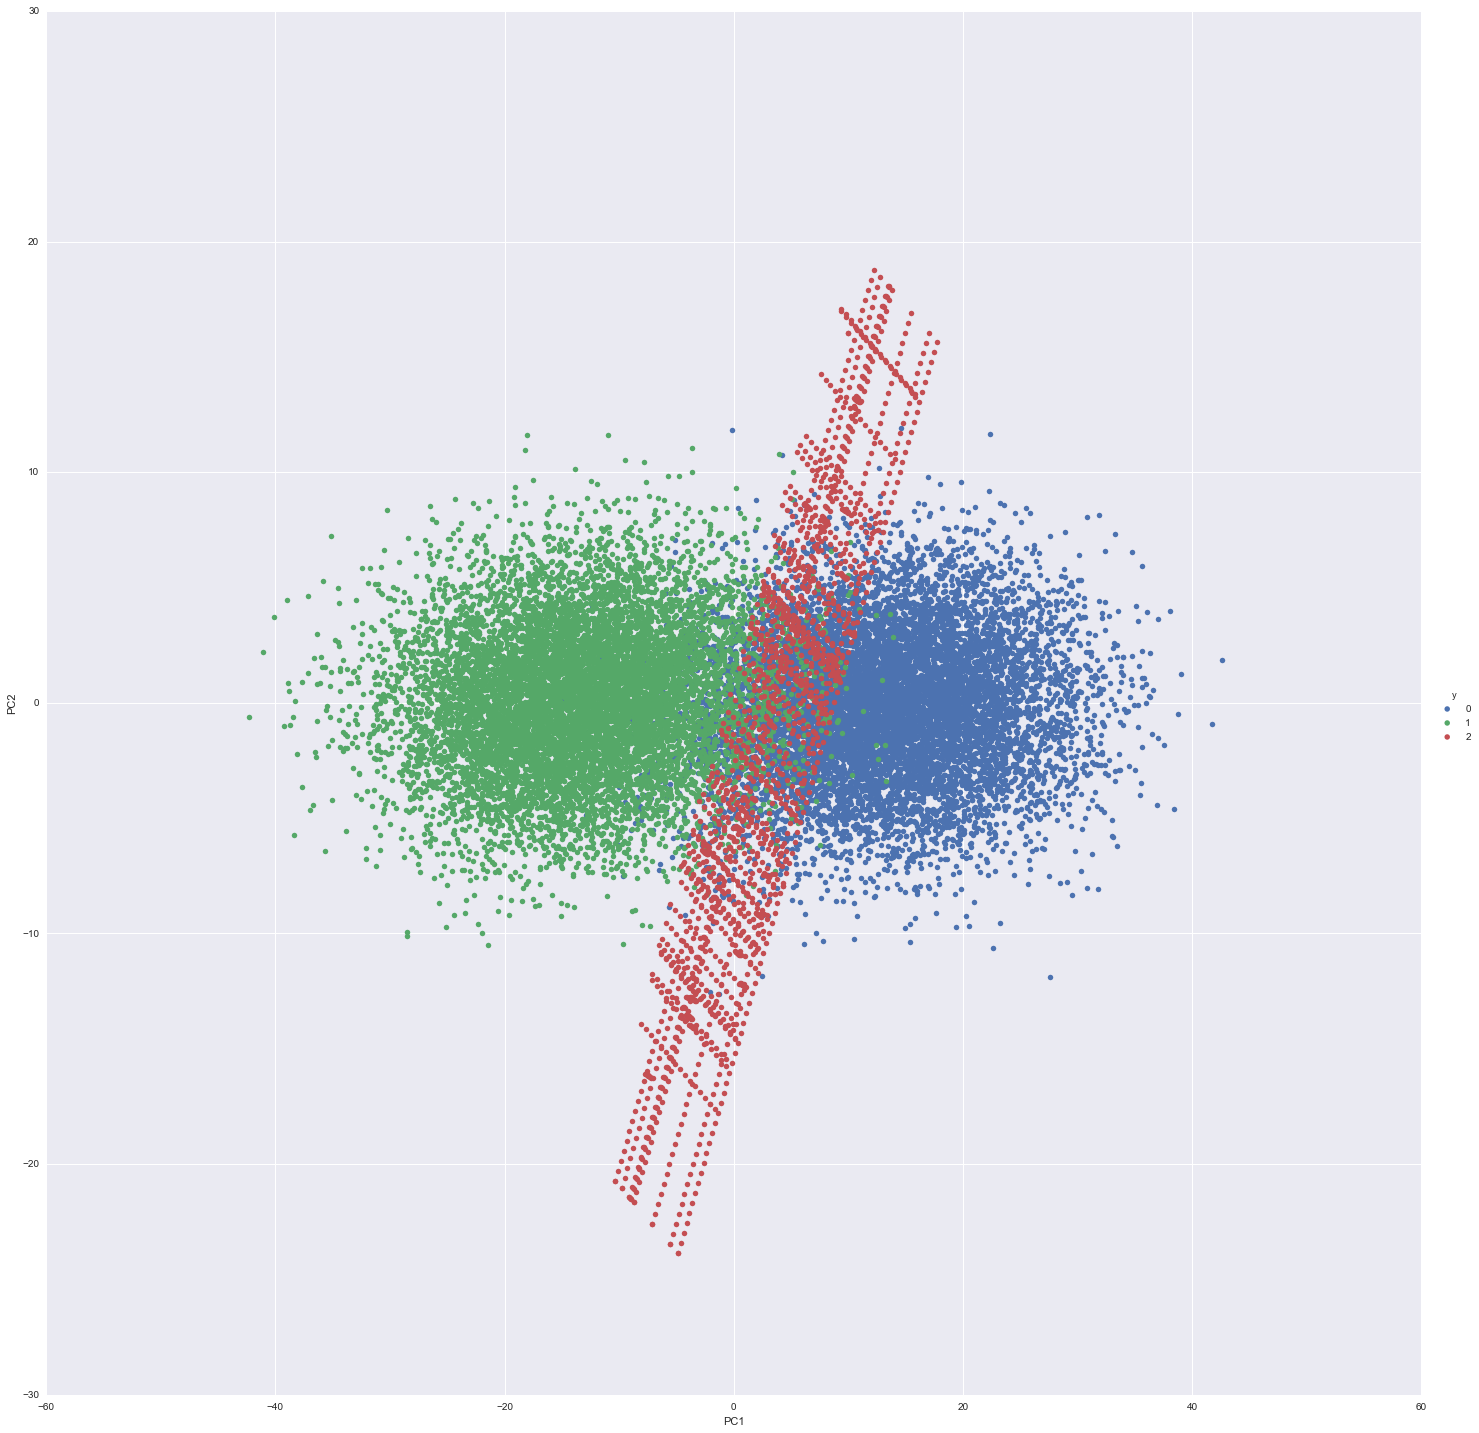

In [448]:
ffPointspointsPca = pd.DataFrame(pcaMod.transform(ffPoints), columns=['PC1', 'PC2'])
ffPointspointsPca['y'] = [2] * ffPointspointsPca.shape[0]

con = pd.concat([xPca, ffPointspointsPca], ignore_index=True)

sns.lmplot(data=con, x='PC1', y='PC2', hue='y', fit_reg=False, size=20, scatter_kws={'s': 30, 'alpha': 1})
plt.show()